In [19]:
import seaborn_plot_util
%matplotlib notebook
import re
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
import spacy
from matplotlib import pyplot as plt
import sys
from scipy import stats
import seaborn_plot_util
import pprint
import json
import os
from pathlib import Path
import util
from importlib import reload

pp = pprint.PrettyPrinter(indent=4)
myprint = pp.pprint

nlp = spacy.load("en_core_web_md")

In [20]:
saves_dir = os.path.join("../saves", "negation_dep_parsing_2_hops")
Path(saves_dir).mkdir(parents=True, exist_ok=True) 
Path(os.path.join(saves_dir, "all")).mkdir(parents=True, exist_ok=True) 
datasets = json.loads(open("../input.json").read())
preload_flag = True
plot_save_prefix = "pos_neg_negation_depparsing"
analysis_types = [
    "word_level", 
    "sent_level", 
    "review_level"
]

if not preload_flag:
    seed_val = 23
    np.random.seed(seed_val)

    vader_sentiment_scores = vader_negation_util.read_vader_sentiment_dict(VADER_LEXICON_PATH)

    negation_count_data = {}
    pos_negation_count_data = {}
    neg_negation_count_data = {}

    selected_samples = {}
    for data in datasets:
        myprint(data)
        selected_samples[data["name"]] = {}
        for category in ["positive", "negative"]:
            texts = util.read_file(data[category]["data_filepath"])
            n_samples = None
            if "n_samples" in data[category]:
                n_samples = data[category]["n_samples"]
            selected_texts = util.get_samples(texts, n_samples)
            selected_samples[data["name"]][category] = selected_texts

    plot_data = {}
    plot_data_overall_negation = {}

    for a_type in analysis_types:
        plot_data[a_type] = []
        plot_data_overall_negation[a_type] = []

    for data in datasets:
        dep_data = {}
        for category in ["positive", "negative"]:
            dep_data[category] = []
            negation_count_data = {}
            pos_negation_count_data = {}
            neg_negation_count_data = {}
            for a_type in analysis_types:
                negation_count_data[a_type] = []
                pos_negation_count_data[a_type] = []
                neg_negation_count_data[a_type] = []

            selected_texts = selected_samples[data["name"]][category]
            for text in selected_texts:
                negation_count_dict, pos_negation_count_dict, neg_negation_count_dict, dep_dict = count_negation(text, 
                    vader_sentiment_scores)
                for a_type in analysis_types:
                    negation_count_data[a_type].append(negation_count_dict[a_type])
                    pos_negation_count_data[a_type].append(pos_negation_count_dict[a_type])
                    neg_negation_count_data[a_type].append(neg_negation_count_dict[a_type])                    

            dep_data[category].append({
                "text": text,
                "dep_info": dep_dict                        
            })
            for a_type in analysis_types:
                plot_data[a_type].append({
                    "category": "negative - "+category+" review ",
                    "review category": category,
                    "text sentiment": "negative",
                    "name": data["name"],
                    "value": np.mean(neg_negation_count_data[a_type]),
                    "sem_value": stats.sem(neg_negation_count_data[a_type]),
                    "all_samples_data": neg_negation_count_data[a_type]
                })
                plot_data[a_type].append({
                    "category": "positive - "+category+" review ",
                    "review category": category,
                    "text sentiment": "positive",
                    "name": data["name"],
                    "value": np.mean(pos_negation_count_data[a_type]),
                    "sem_value": stats.sem(pos_negation_count_data[a_type]),
                    "all_samples_data": pos_negation_count_data[a_type]
                })
                plot_data_overall_negation[a_type].append({
                    "category": category,
                    "name": data["name"],
                    "value": np.mean(negation_count_data[a_type]),
                    "sem_value": stats.sem(negation_count_data[a_type]),
                    "all_samples_data": negation_count_data[a_type]
                })
        pickle.dump(dep_data, 
            open(os.path.join(saves_dir, data["name"]+"_depparsing_data.pickle"), "wb")
        )

    pickle.dump(plot_data, 
        open(os.path.join(saves_dir, "all", plot_save_prefix+".pickle"), "wb")
    )
    pickle.dump(plot_data_overall_negation, 
        open(os.path.join(saves_dir, "all", "overall.pickle"), "wb")
    )
else:
    plot_data = pickle.load(open(os.path.join(saves_dir, "all", plot_save_prefix+".pickle"), "rb"))
    plot_data_overall_negation = pickle.load(open(os.path.join(saves_dir, "all", "overall.pickle"), "rb"))


'sent_level'
../saves/negation_dep_parsing_2_hops/all/pos_neg_negation_depparsing_sent_level_non_amz
../saves/negation_dep_parsing_2_hops/all/pos_neg_negation_depparsing_sent_level_non_amz


<IPython.core.display.Javascript object>


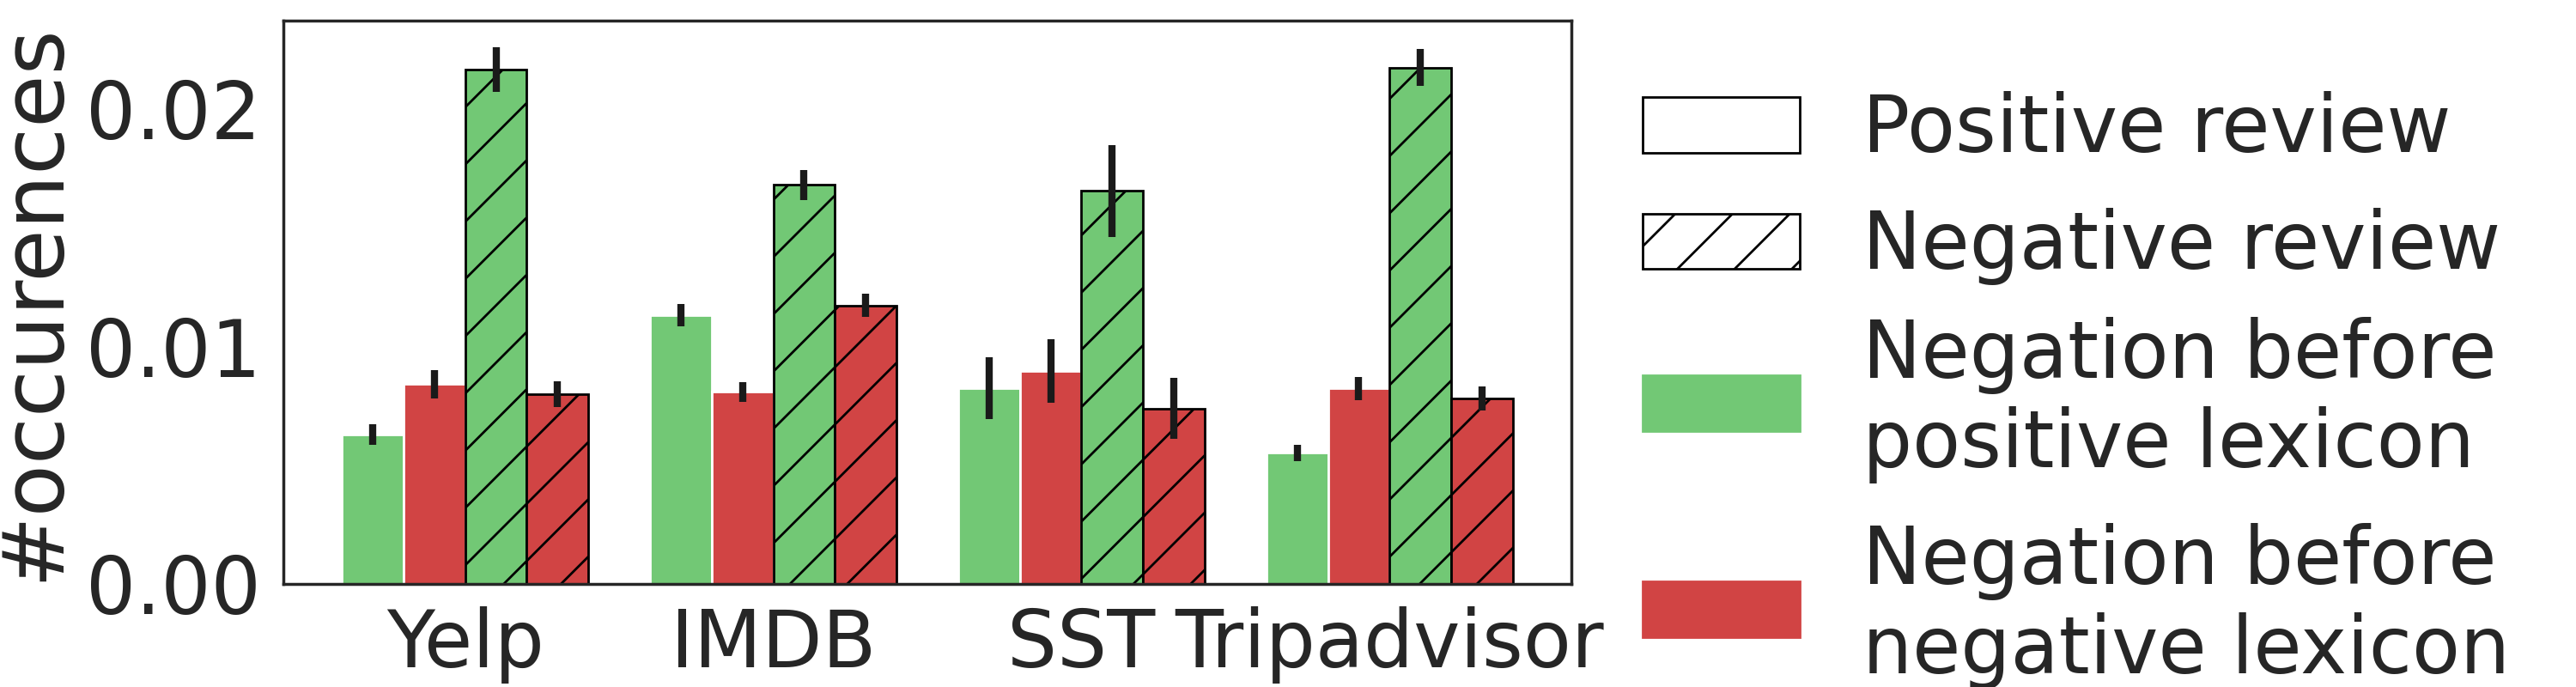

../saves/negation_dep_parsing_2_hops/all/pos_neg_negation_depparsing_sent_level_amz
../saves/negation_dep_parsing_2_hops/all/pos_neg_negation_depparsing_sent_level_amz


<IPython.core.display.Javascript object>


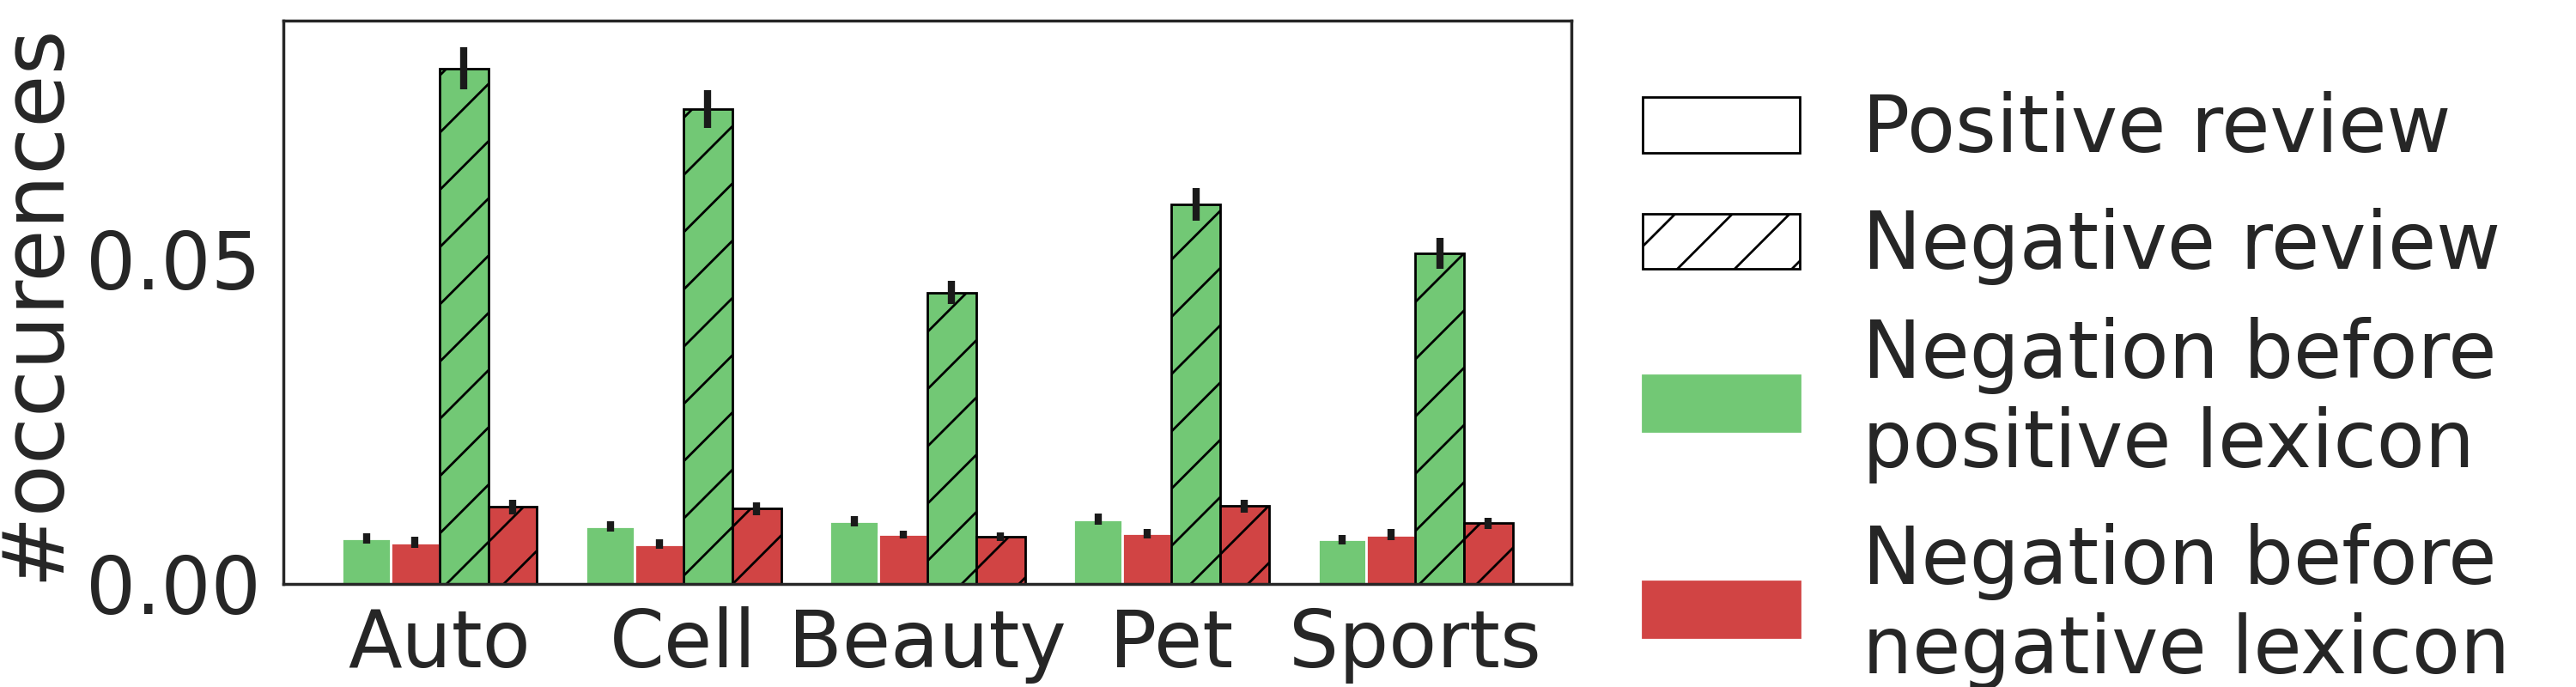

'review_level'
../saves/negation_dep_parsing_2_hops/all/pos_neg_negation_depparsing_review_level_non_amz
../saves/negation_dep_parsing_2_hops/all/pos_neg_negation_depparsing_review_level_non_amz


<IPython.core.display.Javascript object>


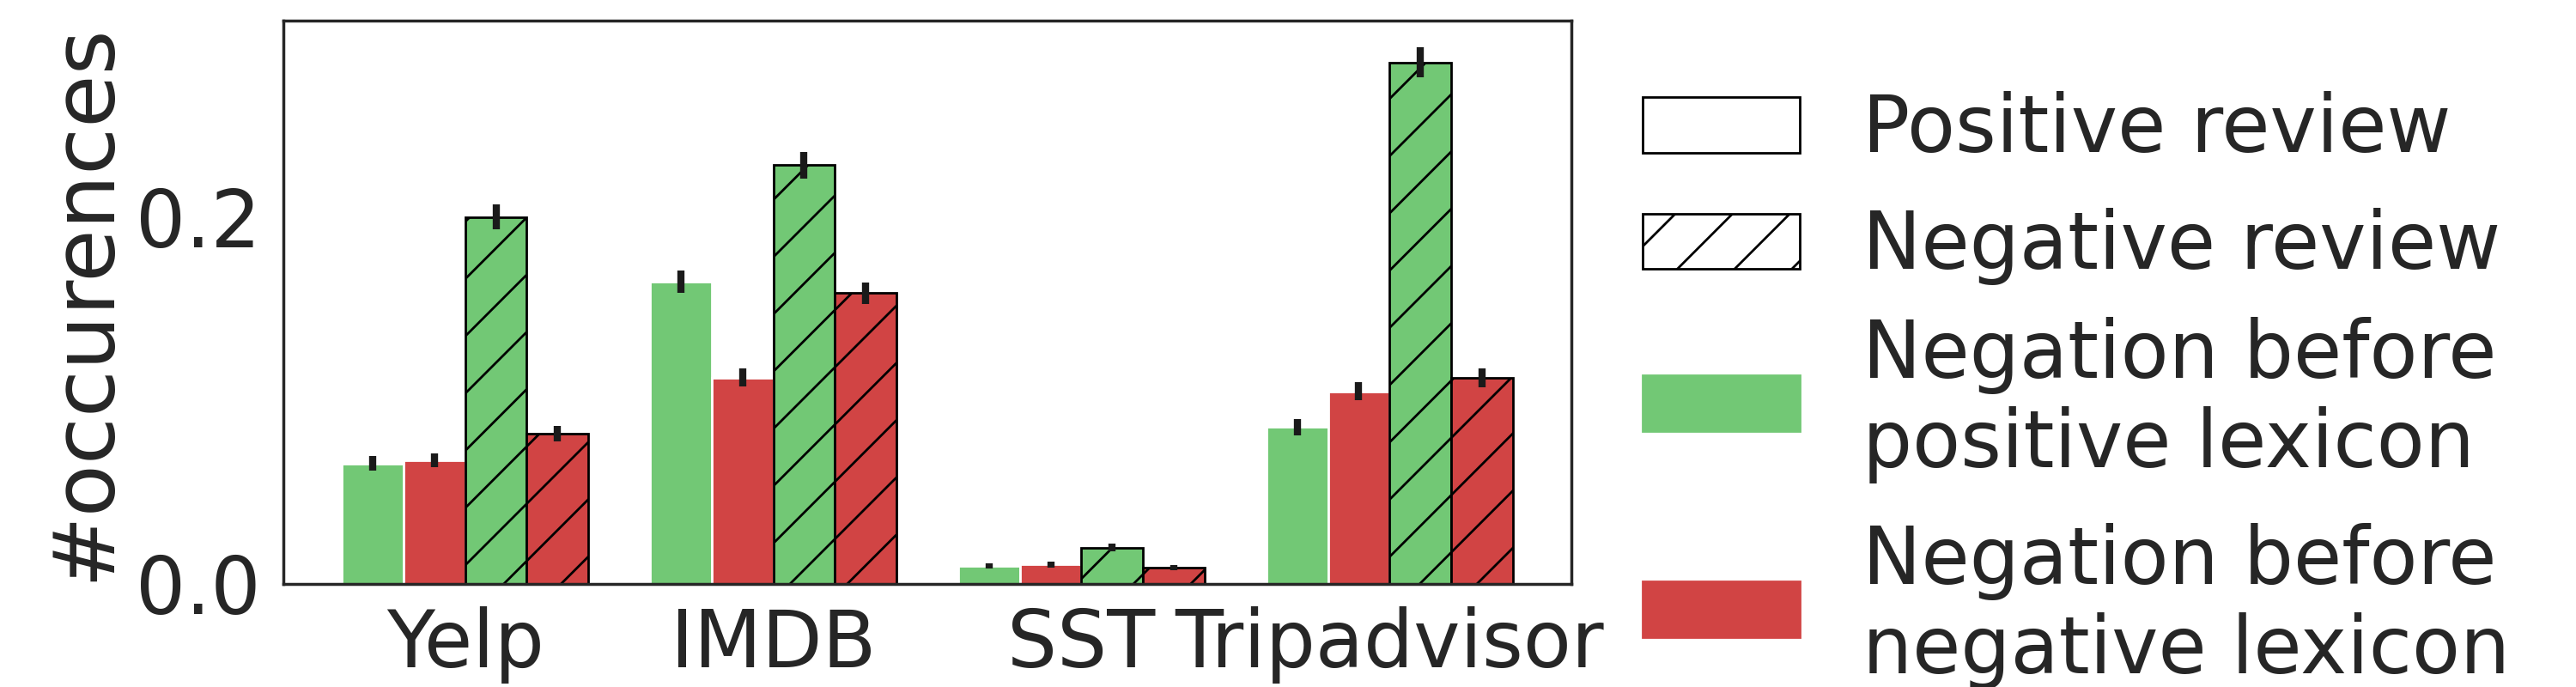

../saves/negation_dep_parsing_2_hops/all/pos_neg_negation_depparsing_review_level_amz
../saves/negation_dep_parsing_2_hops/all/pos_neg_negation_depparsing_review_level_amz


<IPython.core.display.Javascript object>


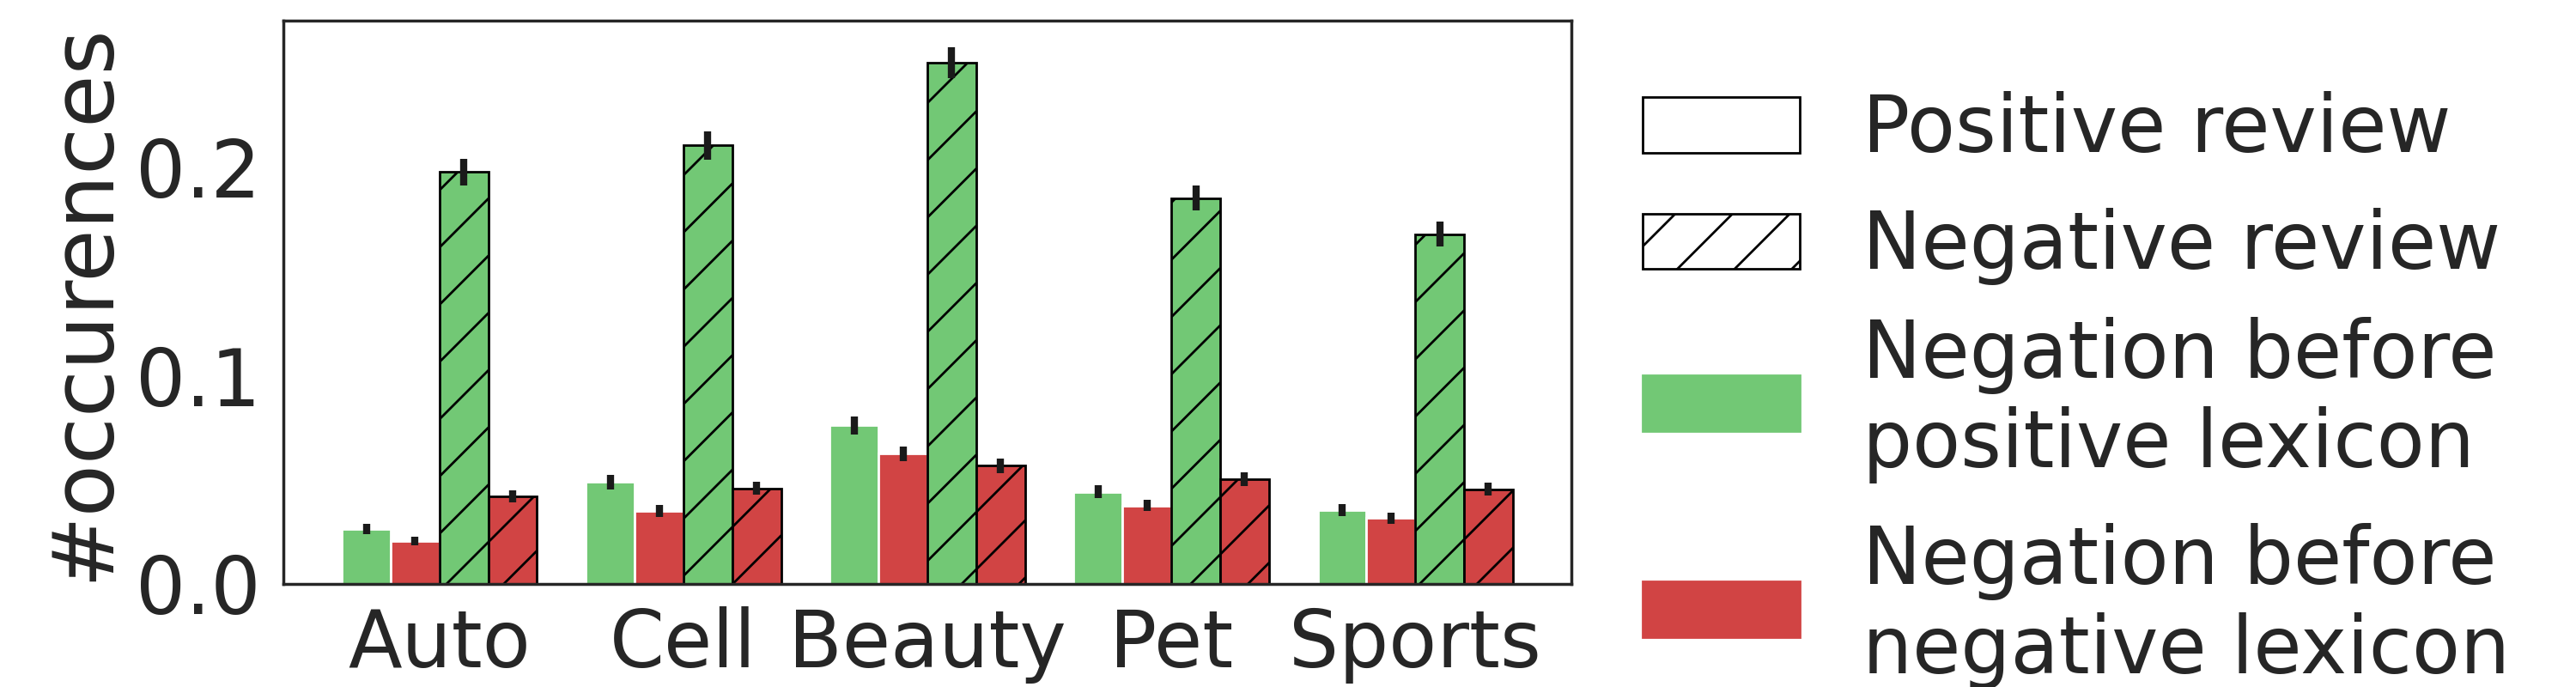

In [27]:

for analysis in analysis_types[1:]:   
    myprint(analysis)     
    amazon_data, non_amazon_data = util.filter_amazon(plot_data[analysis])
    
    seaborn_plot_util.draw_grouped_barplot_four_subbars(non_amazon_data, "name", "value", 
        "category", 
        os.path.join(saves_dir, "all", plot_save_prefix+"_"+analysis+"_non_amz"),
        figsize=(15, 4), position=(0.11, 0.15, 0.5, 0.82),
    #   ylim_top=None, 
        bbox_to_anchor=(1, 0.5, 0.2, 0.5),
        y_axis_name="#occurences",
        negation=True)

    seaborn_plot_util.draw_grouped_barplot_four_subbars(amazon_data, "name", "value", 
            "category", 
            os.path.join(saves_dir, "all",
            plot_save_prefix+"_"+str(analysis)+"_amz"),
            figsize=(15, 4), position=(0.11, 0.15, 0.5, 0.82),
#             ylim_top=None, 
            bbox_to_anchor=(1, 0.5, 0.2, 0.5),
            amazon_data_flag=True,
            y_axis_name="#occurences",
            negation=True)
    
    
#     ylim_top = max([float(d["value"]) for d in non_amazon_data])
#     ylim_top = 1.7*ylim_top

#     seaborn_plot_util_old.draw_grouped_barplot_four_subbars(non_amazon_data, "name", "value", 
#         "category", 
#         os.path.join(saves_dir, "all", 
#         plot_save_prefix+"_"+str(analysis)+"_non_amz"),
#         ylim_top=ylim_top,
#         negation=True,
#         y_axis_name="#occurences")

#     ylim_top =  max([float(d["value"]) for d in amazon_data])
#     ylim_top = 1.7*ylim_top
#     seaborn_plot_util_old.draw_grouped_barplot_four_subbars(amazon_data, "name", "value", 
#         "category", 
#         os.path.join(saves_dir, "all", 
#         plot_save_prefix+"_"+str(analysis)+"_amz"),
#         ylim_top=ylim_top,
#         negation=True,
#         y_axis_name="#occurences", amazon_data_flag=True)


Overall negation



'sent_level'
-----------
../saves/negation_dep_parsing_2_hops/all/overall_negation_sent_level_amz


<IPython.core.display.Javascript object>


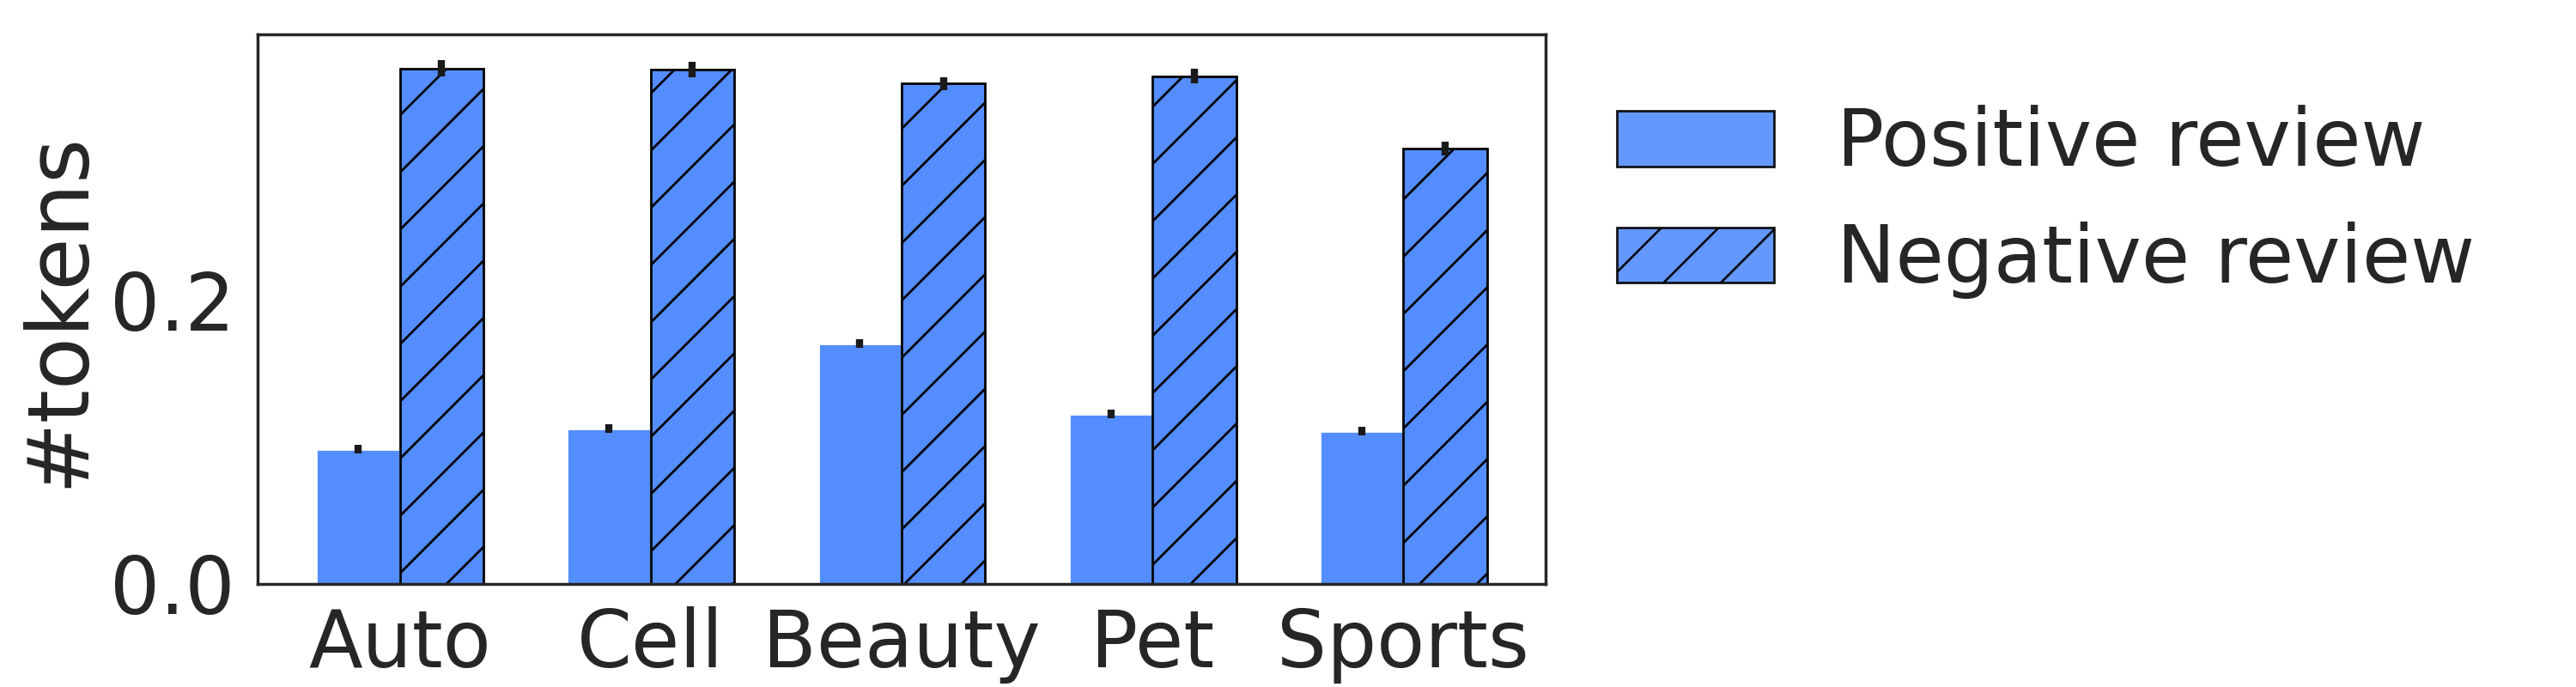

../saves/negation_dep_parsing_2_hops/all/overall_negation_sent_level_non_amz


<IPython.core.display.Javascript object>


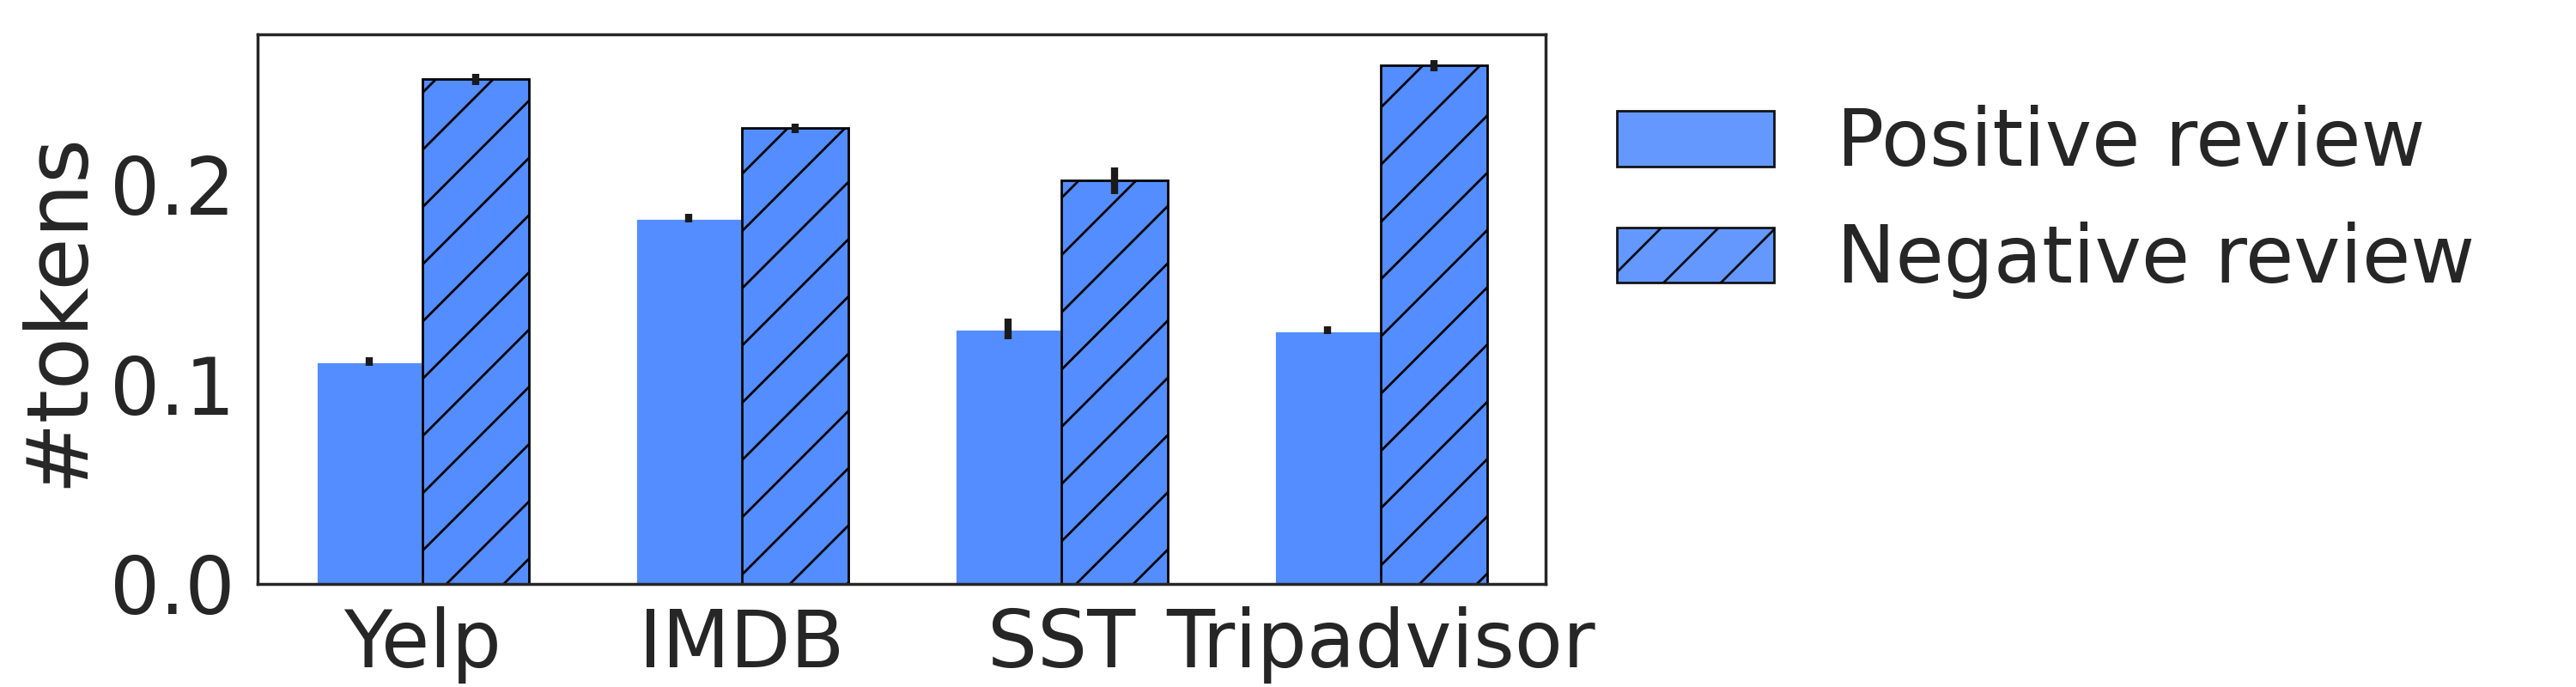


'review_level'
-----------
../saves/negation_dep_parsing_2_hops/all/overall_negation_review_level_amz


<IPython.core.display.Javascript object>


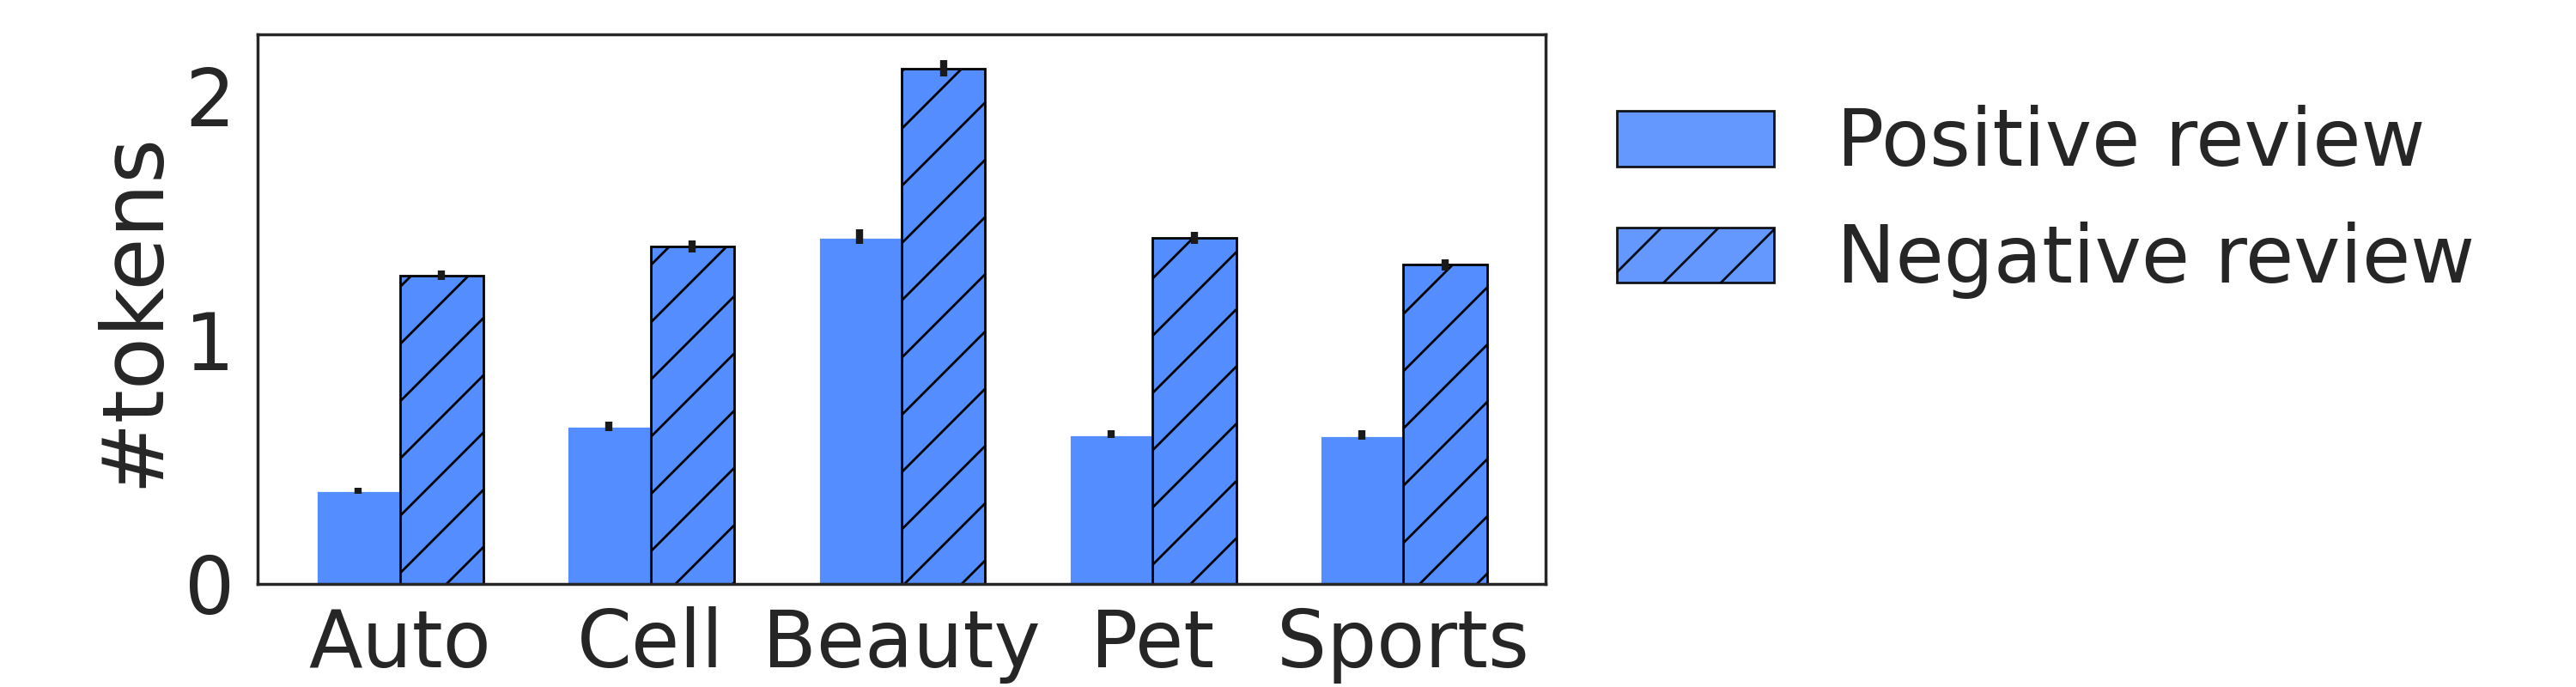

../saves/negation_dep_parsing_2_hops/all/overall_negation_review_level_non_amz


<IPython.core.display.Javascript object>


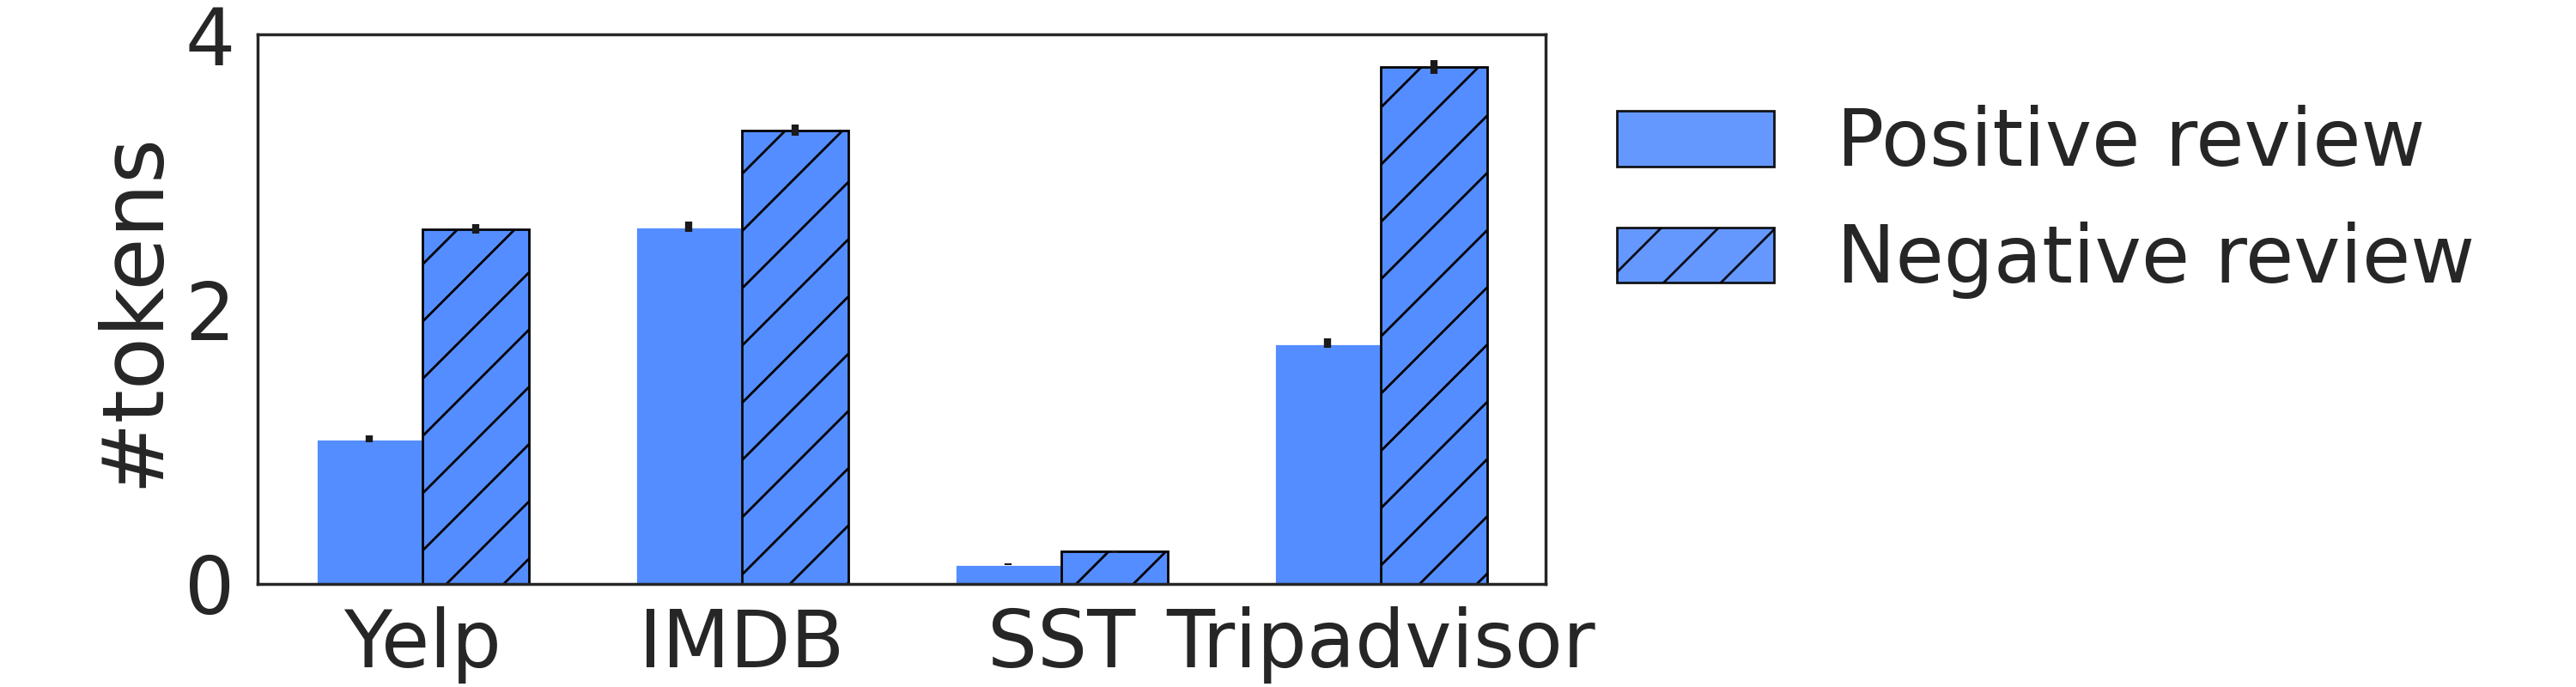

In [36]:
reload(seaborn_plot_util)
print("Overall negation\n\n")
for analysis in analysis_types[1:]:   
    print()
    myprint(analysis)     
    print("-----------")
    amazon_data, non_amazon_data = util.filter_amazon(plot_data_overall_negation[analysis])
    
    seaborn_plot_util.draw_grouped_barplot(amazon_data, "name", "value", 
        "category", os.path.join(saves_dir, "all", "overall_negation_"+analysis+"_amz"),
        figsize=(15, 4), 
        position=(0.1, 0.15, 0.5, 0.8),
        bbox_to_anchor=(1, 0.5, 0.2, 0.5), 
        amazon_data_flag=True)
    
    seaborn_plot_util.draw_grouped_barplot(non_amazon_data, "name", "value", 
        "category", os.path.join(saves_dir, "all", "overall_negation_"+analysis+"_non_amz"),
        figsize=(15, 4), 
        position=(0.1, 0.15, 0.5, 0.8),
        bbox_to_anchor=(1, 0.5, 0.2, 0.5), 
        amazon_data_flag=False)
    
#     ylim_top = max([float(d["value"]) for d in non_amazon_data])
#     ylim_top = 1.7*ylim_top

#     seaborn_plot_util_old.draw_grouped_barplot(non_amazon_data, "name", "value", 
#         "category", 
#         os.path.join(saves_dir, "all", "overall_negation_"+str(analysis)+"_non_amz"),
#         ylim_top=ylim_top,
#         y_axis_name="#occurences")

# #     ylim_top =  max([float(d["value"]) for d in amazon_data])
# #     ylim_top = 1.7*ylim_top
#     seaborn_plot_util_old.draw_grouped_barplot(amazon_data, "name", "value", 
#         "category", 
#         os.path.join(saves_dir, "all", "overall_negation_"+str(analysis)+"_amz"),
#         ylim_top=ylim_top,
#         y_axis_name="#occurences", amazon_data_flag=True)